## Import Packages + Setup

In [151]:
# Data Management
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import sqlite3

# Visualization
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

# Pre-processing
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree

# Evaluating model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [67]:
# Set connection to SQL database and save datasets
conn = sqlite3.connect("Final_Project.sqlite")
election_results = pd.read_sql('select * from Election_Results',conn)
prev_pres = pd.read_sql('select * from Previous_Presidents',conn)
gdp = pd.read_sql('select * from Econ',conn)
states = pd.read_sql('select * from States',conn)
turnout = pd.read_sql('select * from Turnout',conn)
total_data = pd.read_sql('select * from Total_Data',conn)
conn.close()

# Set different key states
key_states = ['New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada', 'Wisconsin', 'New Hampshire', 'Michigan']
swing_states_overall = ['New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada']
swing_states_accurate = ['Ohio', 'Nevada', 'Pennsylvania', 'New Mexico', 'Wisconsin', 'New Hampshire', 'Michigan']

## Examine and change data

<AxesSubplot:>

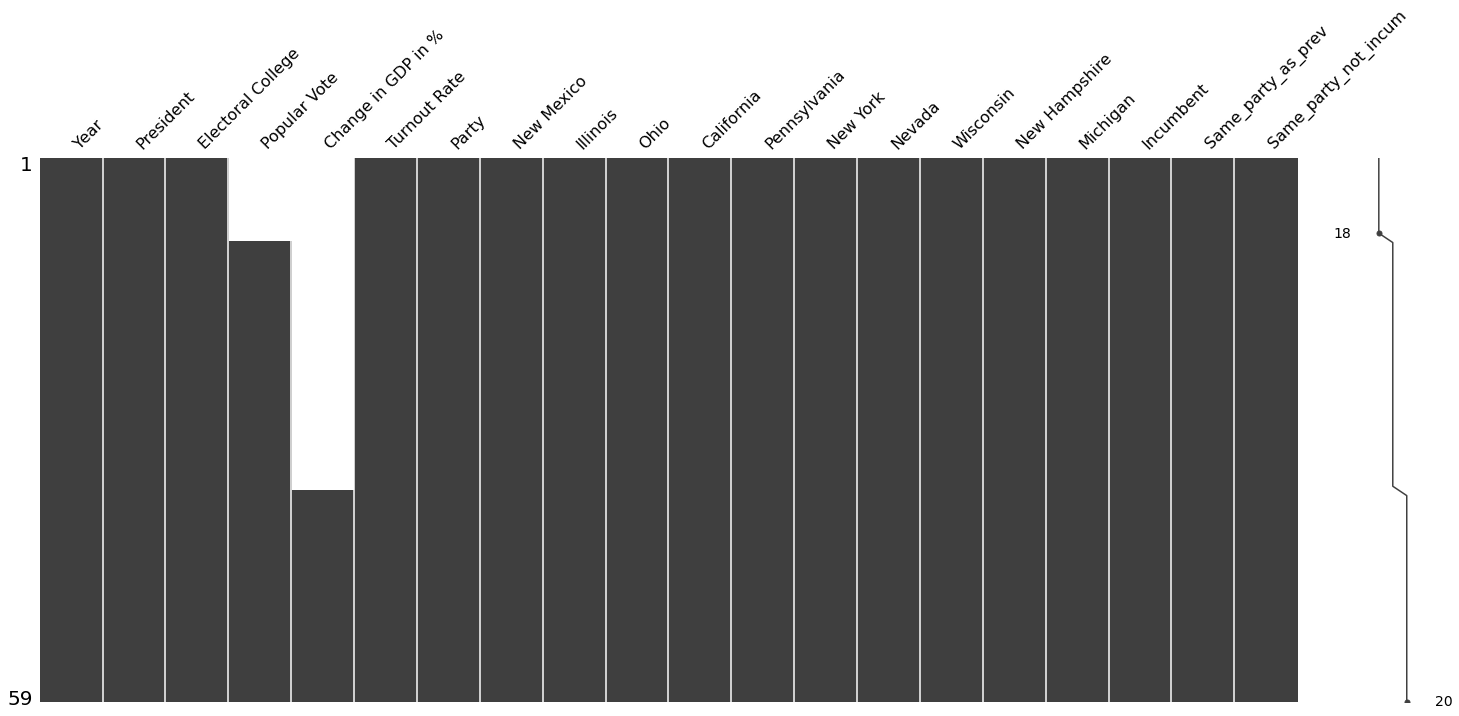

In [68]:
miss.matrix(total_data)

Popular Vote doesn't have values for the first couple years because it wasn't measured. However, Popular Vote is better than electoral college which is often not great so I'm going to keep it for now, potentially subset the data to be where popular vote starts being measured. Similarly, might subset data to where change in gdp starts being measured and see how predictive it is then

In [69]:
# Make party a categorical variable: R is 0, D is 1, other is 2
# Ordered by how many times each party won
total_data.Party.replace({'R': 0, 'D': 1, 'DR': 2, 'W': 3, 'GW': 4, 'F': 5, 'Adams': 6}, inplace = True)

In [70]:
# Create a couple subsets of the data

# Popular vote as measure, needs to be once Popular Vote is measured
pop_vote_data = total_data[total_data['Popular Vote'].notna()]
# Once GDP started being measured
gdp_data = total_data[total_data['Change in GDP in %'].notna()]
# Only using overall swing states
swing_historic = total_data.drop(columns = ['Wisconsin', 'New Hampshire', 'Michigan'])
# Only using more accurate swing
swing_accurate = total_data.drop(columns = ['Illinois', 'California', 'New York'])


## Pipeline function

In [152]:
# Function to make testing different data easier
def model():
    
    # Set folds
    fold_generator = KFold(n_splits=10, shuffle=True, random_state = 7777)
    
    # Create Pipeline
    pipe = Pipeline(steps = [('pre_process', pp.MinMaxScaler()), ('model', None)])
    
    # Specify models and tuning parameters
    search_space = [
        
        # Linear Model
        {'model' : [LM()]},
        
        # Bagging Model
        {'model': [Bag()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
         'model__n_neighbors':[1,2,5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
         'model__max_depth':[1,2,3,4,5,6]},
    
        # Random forest with the N Estimators tuning param
        {'model' : [RF()],
        'model__max_depth':[1,2,3,4,5],
        'model__n_estimators':[250,500,1000,1500,1750]}
    ]
    
    # Search for best model
    search = GridSearchCV(pipe, search_space, 
                          cv = fold_generator, 
                          scoring = 'neg_mean_squared_error', 
                          n_jobs = 4)
    
    # Fit model to training data
    return(search)
    

In [153]:
search = model()

In [204]:
# Total Data study using Electoral College share - ignore GDP
# Split Data 
y = total_data['Electoral College']
x = total_data.iloc[:,5:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -249.638857965
The best parameter is {'model': BaggingRegressor()}
29.358646765957445
0.8871658858470486


In [205]:
# Data study using popular vote share as measure, ignore GDP
# Split Data 
y = pop_vote_data['Popular Vote']
x = pop_vote_data.iloc[:,5:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -25.59701549336723
The best parameter is {'model': LinearRegression()}
10.03894536813338
0.6540295960480315


In [208]:
# Data study that includes GDP, looking at Electoral College share
# Split Data 
y = gdp_data['Electoral College']
x = gdp_data.iloc[:,4:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -269.7292254999999
The best parameter is {'model': BaggingRegressor()}
39.23442555555553
0.8654161142817326


In [207]:
# Data study that includes GDP, looking at Popular Vote share
# Split Data 
y = gdp_data['Popular Vote']
x = gdp_data.iloc[:,4:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -38.050694999999976
The best parameter is {'model': BaggingRegressor()}
6.237966666666654
0.7419632536281016


In [192]:
swing_overall = total_data[['Electoral College', 'New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada']]
swing_accurate = total_data[['Electoral College', 'Ohio', 'Nevada', 'Pennsylvania', 'New Mexico', 'Wisconsin', 'New Hampshire', 'Michigan']]


In [202]:
# See which is more accurate, swing states overall or accurate swing states
# Split Data 
y = swing_overall['Electoral College']
x = swing_overall.iloc[:,1:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -307.94799741717577
The best parameter is {'model': BaggingRegressor()}
148.696781027325
0.42851352453790637


In [203]:
# Split Data 
y = swing_accurate['Electoral College']
x = swing_accurate.iloc[:,1:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print(m.mean_squared_error(train_y,pred_y))
print(m.r2_score(train_y,pred_y))

The best score is -187.97567462973882
The best parameter is {'model': BaggingRegressor()}
91.36397834360561
0.648860737891916


It seems like the accurate swing states predict better

## Model Interpretation
It seems like overall, using electoral college w/out gdp is best

In [211]:
# Look at it again
y = total_data['Electoral College']
x = total_data.iloc[:,5:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)
rf_mod = search.best_estimator_

In [212]:
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=25)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Turnout Rate,0.493814,0.101749,0.290317,0.697311
1,Pennsylvania,0.176532,0.033316,0.109900,0.243164
2,Incumbent,0.169935,0.048777,0.072380,0.267490
3,New Hampshire,0.147104,0.039961,0.067182,0.227026
4,Ohio,0.078819,0.017273,0.044272,0.113365
5,Party,0.078314,0.019640,0.039033,0.117595
6,Illinois,0.062755,0.018833,0.025089,0.100421
7,Nevada,0.057946,0.024720,0.008505,0.107387
8,New York,0.035023,0.008904,0.017216,0.052831
9,Same_party_as_prev,0.034489,0.009393,0.015703,0.053276


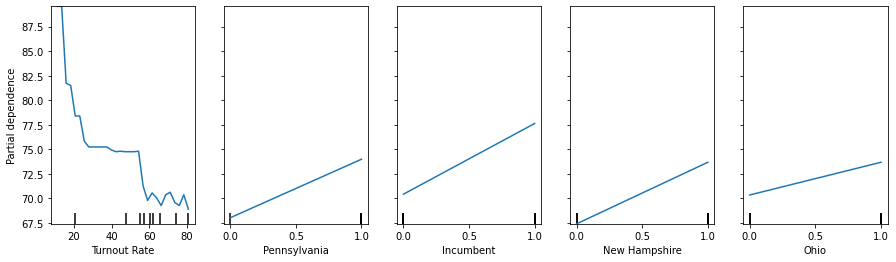

In [213]:
# Target specific features
features = ['Turnout Rate','Pennsylvania','Incumbent','New Hampshire','Ohio']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_x, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

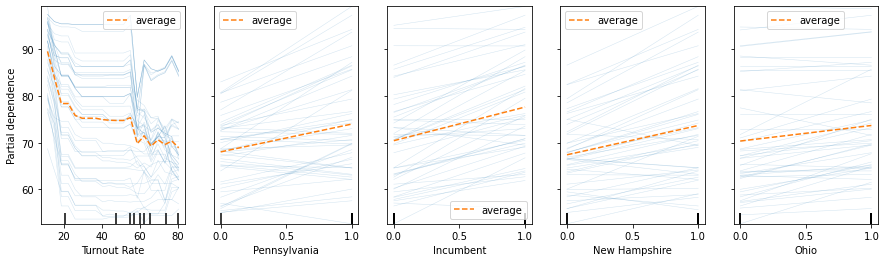

In [214]:
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_x,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)